# Exploratory Data Analysis – Sales Performance

This notebook focuses on identifying **what is happening**, **where it is happening**, and **why it matters** with respect to win rate decline and revenue risk.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = "../data/raw/skygeni_sales_data.csv"
df = pd.read_csv(DATA_PATH)

df["created_date"] = pd.to_datetime(df["created_date"])
df["closed_date"] = pd.to_datetime(df["closed_date"], errors="coerce")

df.head()


,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome
0,D00001,2023-11-24,2023-12-15,rep_22,SaaS,North America,Enterprise,Referral,Qualified,4253,21,Won
1,D00002,2023-01-17,2023-01-27,rep_7,SaaS,India,Core,Referral,Closed,3905,10,Won
2,D00003,2023-10-29,2023-12-10,rep_5,HealthTech,APAC,Core,Inbound,Proposal,10615,42,Lost
3,D00004,2023-07-14,2023-08-02,rep_18,FinTech,India,Core,Partner,Negotiation,4817,19,Won
4,D00005,2024-02-29,2024-05-26,rep_2,HealthTech,APAC,Core,Outbound,Qualified,45203,87,Lost


In [2]:
df["is_won"] = (df["outcome"].str.lower() == "won").astype(int)
df["close_quarter"] = df["closed_date"].dt.to_period("Q").astype(str)
df["deal_age_days"] = (df["closed_date"] - df["created_date"]).dt.days


## Feature Preparation

We derive:
- **is_won** to calculate win rates
- **close_quarter** to analyze trends over time
- **deal_age_days** to understand deal duration and risk

These features allow us to move from raw data to business-relevant metrics.


In [3]:
overall_win_rate = df["is_won"].mean()
overall_win_rate


np.float64(0.4526)

## Overall Win Rate

The overall win rate represents the percentage of deals that successfully convert into revenue.
This serves as a **baseline** against which all further segment and trend analysis is compared.


In [4]:
quarterly_win_rate = (
    df.groupby("close_quarter")["is_won"]
      .mean()
      .reset_index()
      .sort_values("close_quarter")
)

quarterly_win_rate


,close_quarter,is_won
0,2023Q1,0.445122
1,2023Q2,0.450154
2,2023Q3,0.428150
3,2023Q4,0.475170
4,2024Q1,0.466667
5,2024Q2,0.437991
6,2024Q3,0.517241


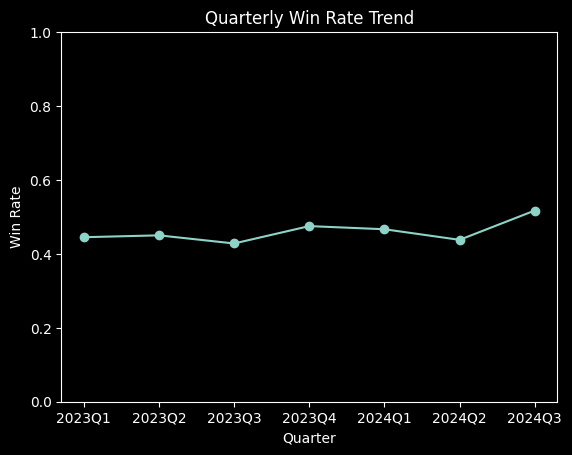

In [5]:
plt.figure()
plt.plot(
    quarterly_win_rate["close_quarter"],
    quarterly_win_rate["is_won"],
    marker="o"
)
plt.xlabel("Quarter")
plt.ylabel("Win Rate")
plt.title("Quarterly Win Rate Trend")
plt.ylim(0, 1)
plt.show()


## Insight: Win Rate Trend

Win rate shows noticeable volatility with a dip in recent high-volume quarters.
This confirms leadership concerns that conversion efficiency has weakened, even though pipeline volume appears healthy.


In [6]:
pipeline_summary = (
    df.groupby("close_quarter")
      .agg(
          deals=("deal_id", "count"),
          total_revenue=("deal_amount", "sum"),
          win_rate=("is_won", "mean")
      )
      .reset_index()
      .sort_values("close_quarter")
)

pipeline_summary


,close_quarter,deals,total_revenue,win_rate
0,2023Q1,328,7689967,0.445122
1,2023Q2,973,24880389,0.450154
2,2023Q3,1016,27899635,0.428150
3,2023Q4,1027,26799813,0.475170
4,2024Q1,990,26413879,0.466667
5,2024Q2,637,17009398,0.437991
6,2024Q3,29,739383,0.517241


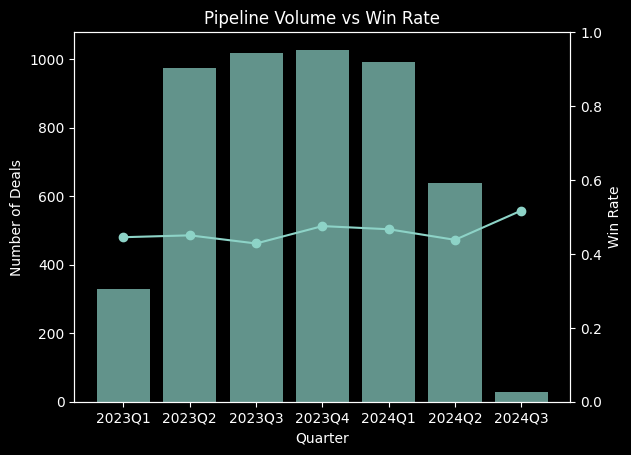

In [7]:
fig, ax1 = plt.subplots()

ax1.bar(
    pipeline_summary["close_quarter"],
    pipeline_summary["deals"],
    alpha=0.7
)
ax1.set_xlabel("Quarter")
ax1.set_ylabel("Number of Deals")

ax2 = ax1.twinx()
ax2.plot(
    pipeline_summary["close_quarter"],
    pipeline_summary["win_rate"],
    marker="o"
)
ax2.set_ylabel("Win Rate")
ax2.set_ylim(0, 1)

plt.title("Pipeline Volume vs Win Rate")
plt.show()


## Insight: Pipeline vs Conversion

Deal volume increased significantly in some periods, but win rate did not improve proportionally.
This indicates a **conversion or qualification issue**, not a demand-generation problem.


In [8]:
stage_win_rate = (
    df.groupby("deal_stage")["is_won"]
      .mean()
      .reset_index()
      .rename(columns={"is_won": "win_rate"})
      .sort_values("win_rate")
)

stage_win_rate


,deal_stage,win_rate
4,Qualified,0.422594
3,Proposal,0.446977
1,Demo,0.458293
2,Negotiation,0.466332
0,Closed,0.467402


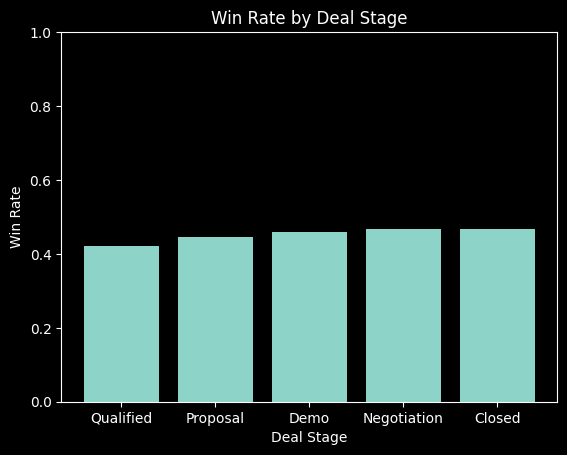

In [9]:
plt.figure()
plt.bar(stage_win_rate["deal_stage"], stage_win_rate["win_rate"])
plt.xlabel("Deal Stage")
plt.ylabel("Win Rate")
plt.title("Win Rate by Deal Stage")
plt.ylim(0, 1)
plt.show()


## Insight: Funnel Leakage

The lowest win rate occurs at the **Qualified** stage.
This suggests that low-quality or poorly qualified deals are entering the pipeline and failing early.


In [10]:
df.groupby("outcome")["sales_cycle_days"].mean()


outcome
Lost    64.230179
Won     63.173221
Name: sales_cycle_days, dtype: float64

## Insight: Sales Cycle Duration

Average sales cycle duration is similar for won and lost deals.
This suggests that **deal quality and fit**, rather than time spent, are more critical drivers of success.


In [11]:
baseline = df["is_won"].mean()

lead_source_drivers = (
    df.groupby("lead_source")["is_won"]
      .mean()
      .reset_index()
      .rename(columns={"is_won": "win_rate"})
)

lead_source_drivers["impact_vs_baseline"] = (
    lead_source_drivers["win_rate"] - baseline
)

lead_source_drivers.sort_values("impact_vs_baseline")


,lead_source,win_rate,impact_vs_baseline
2,Partner,0.439516,-0.013084
1,Outbound,0.455056,0.002456
3,Referral,0.455272,0.002672
0,Inbound,0.460380,0.007780


## Insight: Lead Source Impact

Inbound leads outperform the company average, while Partner leads underperform.
This indicates that lead quality from Partner sources is dragging down overall win rate.


## Executive Summary for Sales Leadership

- Pipeline volume is healthy, but conversion efficiency has declined.
- Win rate volatility is driven by early-stage deal leakage.
- Qualification quality, especially for Partner-sourced leads, is a key issue.
- Sales cycle duration alone does not explain deal losses.

These insights motivate the need for proactive deal risk scoring,
revenue forecasting, and targeted sales interventions.
